Aluno: Daniel Gleison Moreira Lira \
Aplicação: Machine Learning


# Detecção preditiva de fraudes financeiras utilizando aprendizado de máquina
---


## Database

https://www.kaggle.com/ntnu-testimon/paysim1

PS_20174392719_1491204439457_log.csv\
Date created: 2017-03-31

### Predicted attribute:
Class of fraud detection

### Number of Instances:
6.353.307

### Number of Attributes:
11 attributes (5 Decimal, 3 Integer, 3 String) and the class

### Attribute Information:

This is a sample of 1 row with headers explanation:

1,PAYMENT,1060.31,C429214117,1089.0,28.69,M1591654462,0.0,0.0,0,0

step - maps a unit of time in the real world. In this case 1 step is 1 hour of time. Total steps 744 (30 days simulation).

type - CASH-IN, CASH-OUT, DEBIT, PAYMENT and TRANSFER.

amount - amount of the transaction in local currency.

nameOrig - customer who started the transaction

oldbalanceOrg - initial balance before the transaction

newbalanceOrig - new balance after the transaction

nameDest - customer who is the recipient of the transaction

oldbalanceDest - initial balance recipient before the transaction. Note that there is not information for customers that start with M (Merchants).

newbalanceDest - new balance recipient after the transaction. Note that there is not information for customers that start with M (Merchants).

isFraud - This is the transactions made by the fraudulent agents inside the simulation. In this specific dataset the fraudulent behavior of the agents aims to profit by taking control or customers accounts and try to empty the funds by transferring to another account and then cashing out of the system.

isFlaggedFraud - The business model aims to control massive transfers from one account to another and flags illegal attempts. An illegal attempt in this dataset is an attempt to transfer more than 200.000 in a single transaction.

### Missing Attribute Values: 
None

### Class Distribution: 
2 Classes \
6.354.407 without fraud and 8.213 with fraud

## References:

1. E. A. Lopez-Rojas , A. Elmir, and S. Axelsson. "PaySim: A financial mobile money simulator for fraud detection". In: The 28th European Modeling and Simulation Symposium-EMSS, Larnaca, Cyprus. 2016

In [1]:
# Spark Lib
import findspark
findspark.init()

In [2]:
# Load libraries
import pyspark
from pyspark.sql import SparkSession
from pyspark.ml import Pipeline
from pyspark.ml.classification import DecisionTreeClassifier
from pyspark.ml.feature import StringIndexer, VectorIndexer
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.mllib.util import MLUtils

from pyspark.ml.feature import StringIndexer, IndexToString
from pyspark.ml.feature import VectorAssembler, VectorIndexer
from pyspark.ml.classification import MultilayerPerceptronClassifier
from pyspark.ml.classification import NaiveBayes
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.classification import LinearSVC, OneVsRest
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.classification import DecisionTreeClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

from pyspark.ml.linalg import Vectors
from pyspark.mllib.util import MLUtils

## SKLearn Lib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.model_selection import cross_val_score

import time
start_time = time.time()
%matplotlib inline

## Configure parameters

In [3]:
# Path to dataset file
data_path='./data/'

# Sample of train and test dataset

# [0.7,0.3] => 70% for train and 30% for test
# [1.0,0.2] => 100% for train and 20% for test, not good, acuracy always 100%
# [0.1,0.02] => 10% for train and 2% for test, if big datasets

train_sample = 0.7
test_sample = 0.3

## Read and show dataset

In [4]:
# Importing the dataset
ds_original = pd.read_csv(data_path+'PS_20174392719_1491204439457_log.csv')

In [5]:
ds_original.shape
print("Number of itens per class")
ds_original.groupby('isFraud').size()

Number of itens per class


isFraud
0    6354407
1       8213
dtype: int64

In [6]:
ds_original.describe()

,step,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
count,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06
mean,2.433972e+02,1.798619e+05,8.338831e+05,8.551137e+05,1.100702e+06,1.224996e+06,1.290820e-03,2.514687e-06
std,1.423320e+02,6.038582e+05,2.888243e+06,2.924049e+06,3.399180e+06,3.674129e+06,3.590480e-02,1.585775e-03
min,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,1.560000e+02,1.338957e+04,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,2.390000e+02,7.487194e+04,1.420800e+04,0.000000e+00,1.327057e+05,2.146614e+05,0.000000e+00,0.000000e+00
75%,3.350000e+02,2.087215e+05,1.073152e+05,1.442584e+05,9.430367e+05,1.111909e+06,0.000000e+00,0.000000e+00
max,7.430000e+02,9.244552e+07,5.958504e+07,4.958504e+07,3.560159e+08,3.561793e+08,1.000000e+00,1.000000e+00


In [7]:
ds_original.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


In [8]:
ds_original.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6362620 entries, 0 to 6362619
Data columns (total 11 columns):
 #   Column          Dtype  
---  ------          -----  
 0   step            int64  
 1   type            object 
 2   amount          float64
 3   nameOrig        object 
 4   oldbalanceOrg   float64
 5   newbalanceOrig  float64
 6   nameDest        object 
 7   oldbalanceDest  float64
 8   newbalanceDest  float64
 9   isFraud         int64  
 10  isFlaggedFraud  int64  
dtypes: float64(5), int64(3), object(3)
memory usage: 534.0+ MB


In [9]:
ds_original.isnull().sum()

step              0
type              0
amount            0
nameOrig          0
oldbalanceOrg     0
newbalanceOrig    0
nameDest          0
oldbalanceDest    0
newbalanceDest    0
isFraud           0
isFlaggedFraud    0
dtype: int64

## Balanceamento do dataset

In [10]:
## Segregação do dataset em 2 partes (fraud = 0 e fraud = 1)
ds0 = ds_original[ds_original.isFraud==0]
ds1 = ds_original[ds_original.isFraud==1]
len(ds0),len(ds1)

(6354407, 8213)

In [11]:
## Balanceamento do dataset de fraud = 0 com a mesma quantidade de registros do dataset de fraud = 1
ds0 = ds0.sample(n=8213)
len(ds0),len(ds1)

(8213, 8213)

In [12]:
## Concatenação dos datasets de fraud = 0 e fraud = 1 em dataset único
ds_balanceado = pd.concat([ds0,ds1])
ds_balanceado.groupby('isFraud').size()

isFraud
0    8213
1    8213
dtype: int64

In [13]:
ds_balanceado.shape

(16426, 11)

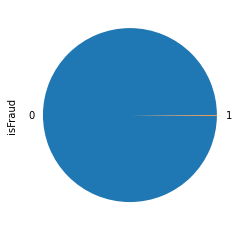

In [14]:
ds_original['isFraud'].value_counts().plot(kind='pie');

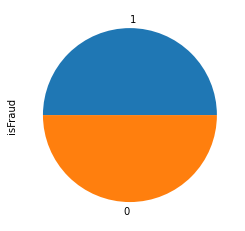

In [15]:
ds_balanceado['isFraud'].value_counts().plot(kind='pie');

In [16]:
ds_balanceado.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
4368292,310,CASH_OUT,78213.98,C2070627471,0.00,0.00,C597128089,2041559.27,2119773.25,0,0
4791611,345,CASH_IN,521687.37,C613411109,2244469.36,2766156.74,C1714223283,1772132.54,1250445.17,0,0
1167313,132,CASH_IN,159115.33,C1483056821,8564744.48,8723859.81,C1601035893,392364.22,233248.89,0,0
3702139,277,CASH_OUT,69191.85,C700683211,31149.00,0.00,C1844561974,777059.60,846251.44,0,0
2906209,228,PAYMENT,10600.29,C1104454711,219662.25,209061.96,M1266414912,0.00,0.00,0,0


## Análise exploratória do dataset balanceado

In [17]:
ds_balanceado.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16426 entries, 4368292 to 6362619
Data columns (total 11 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   step            16426 non-null  int64  
 1   type            16426 non-null  object 
 2   amount          16426 non-null  float64
 3   nameOrig        16426 non-null  object 
 4   oldbalanceOrg   16426 non-null  float64
 5   newbalanceOrig  16426 non-null  float64
 6   nameDest        16426 non-null  object 
 7   oldbalanceDest  16426 non-null  float64
 8   newbalanceDest  16426 non-null  float64
 9   isFraud         16426 non-null  int64  
 10  isFlaggedFraud  16426 non-null  int64  
dtypes: float64(5), int64(3), object(3)
memory usage: 1.5+ MB


In [18]:
ds_balanceado.describe()

,step,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
count,16426.000000,1.642600e+04,1.642600e+04,1.642600e+04,1.642600e+04,1.642600e+04,16426.000000,16426.000000
mean,304.775904,8.213219e+05,1.226330e+06,5.087021e+05,8.469320e+05,1.273413e+06,0.500000,0.000974
std,194.344952,1.852651e+06,3.212927e+06,2.448622e+06,4.005045e+06,4.318786e+06,0.500015,0.031196
min,1.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000
25%,160.000000,3.690378e+04,1.072050e+04,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000
50%,282.000000,1.713974e+05,1.181069e+05,0.000000e+00,0.000000e+00,1.234844e+05,0.500000,0.000000
75%,409.000000,5.406160e+05,7.757786e+05,0.000000e+00,5.167719e+05,1.100875e+06,1.000000,0.000000
max,743.000000,1.773110e+07,5.958504e+07,4.958504e+07,2.551680e+08,2.572833e+08,1.000000,1.000000


In [19]:
## Verificação de dados ausentes no dataset
ds_balanceado.isnull().sum()

step              0
type              0
amount            0
nameOrig          0
oldbalanceOrg     0
newbalanceOrig    0
nameDest          0
oldbalanceDest    0
newbalanceDest    0
isFraud           0
isFlaggedFraud    0
dtype: int64

In [20]:
ds_balanceado.groupby('isFlaggedFraud').size()

isFlaggedFraud
0    16410
1       16
dtype: int64

In [21]:
ds_balanceado.groupby('type')['isFraud'].count()

type
CASH_IN     1733
CASH_OUT    7039
DEBIT         50
PAYMENT     2808
TRANSFER    4796
Name: isFraud, dtype: int64

In [22]:
ds_balanceado[ds_balanceado['isFraud'] == 1].groupby('type')['isFraud'].count()

type
CASH_OUT    4116
TRANSFER    4097
Name: isFraud, dtype: int64

In [23]:
(ds_balanceado[ds_balanceado['isFraud'] == 1].values)

array([[1, 'TRANSFER', 181.0, ..., 0.0, 1, 0],
       [1, 'CASH_OUT', 181.0, ..., 0.0, 1, 0],
       [1, 'TRANSFER', 2806.0, ..., 0.0, 1, 0],
       ...,
       [743, 'CASH_OUT', 6311409.28, ..., 6379898.11, 1, 0],
       [743, 'TRANSFER', 850002.52, ..., 0.0, 1, 0],
       [743, 'CASH_OUT', 850002.52, ..., 7360101.63, 1, 0]], dtype=object)

In [24]:
ds_balanceado.groupby('nameOrig').size()

nameOrig
C1000002591    1
C1000036340    1
C1000086512    1
C1000189561    1
C1000331499    1
              ..
C999560504     1
C999561448     1
C999601858     1
C999624133     1
C99979309      1
Length: 16426, dtype: int64

In [25]:
ds_balanceado.groupby('nameDest').size()

nameDest
C1000039615    1
C1000156006    1
C1000367306    1
C1000407130    1
C1000610515    1
              ..
M998403805     1
M998886223     1
M999138471     1
M999740496     1
M999813234     1
Length: 16248, dtype: int64

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:369: UserWarning: Default bandwidth for data is 0; skipping density estimation.
  warnings.warn(msg, UserWarning)


<Figure size 432x288 with 0 Axes>

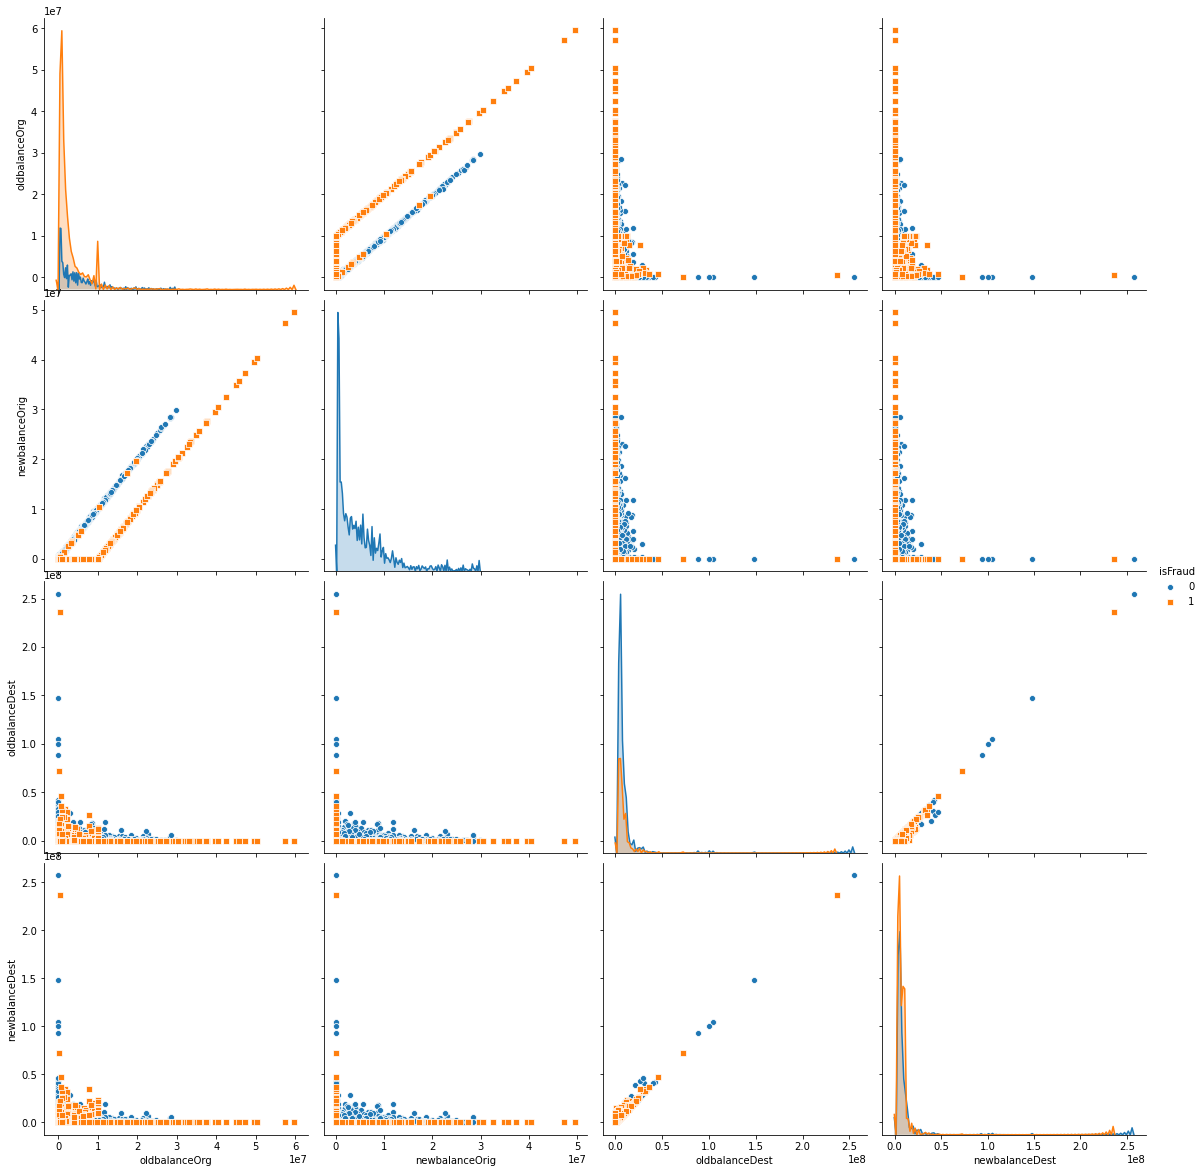

In [26]:
# Matriz de diagramas de dispersão

plt.figure()
sns.pairplot(ds_balanceado, vars = ['oldbalanceOrg','newbalanceOrig','oldbalanceDest','newbalanceDest'], hue = 'isFraud',height=4, markers=['o', 's'])
plt.show()

In [27]:
#matriz de correlação
ds_balanceado.corr()

,step,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
step,1.000000,0.152317,0.081137,-0.017182,0.000473,0.029738,0.327458,0.037403
amount,0.152317,1.000000,0.660830,0.130671,0.004155,0.223615,0.349049,0.068098
oldbalanceOrg,0.081137,0.660830,1.000000,0.819554,0.004104,0.104508,0.131765,0.064063
newbalanceOrig,-0.017182,0.130671,0.819554,1.000000,0.032244,0.003684,-0.129182,0.093211
oldbalanceDest,0.000473,0.004155,0.004104,0.032244,1.000000,0.945731,-0.075578,-0.006603
newbalanceDest,0.029738,0.223615,0.104508,0.003684,0.945731,1.000000,0.001457,-0.009207
isFraud,0.327458,0.349049,0.131765,-0.129182,-0.075578,0.001457,1.000000,0.031225
isFlaggedFraud,0.037403,0.068098,0.064063,0.093211,-0.006603,-0.009207,0.031225,1.000000


## Transformação do dataset

In [28]:
ds_balanceado

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
4368292,310,CASH_OUT,78213.98,C2070627471,0.00,0.00,C597128089,2041559.27,2119773.25,0,0
4791611,345,CASH_IN,521687.37,C613411109,2244469.36,2766156.74,C1714223283,1772132.54,1250445.17,0,0
1167313,132,CASH_IN,159115.33,C1483056821,8564744.48,8723859.81,C1601035893,392364.22,233248.89,0,0
3702139,277,CASH_OUT,69191.85,C700683211,31149.00,0.00,C1844561974,777059.60,846251.44,0,0
2906209,228,PAYMENT,10600.29,C1104454711,219662.25,209061.96,M1266414912,0.00,0.00,0,0
...,...,...,...,...,...,...,...,...,...,...,...
6362615,743,CASH_OUT,339682.13,C786484425,339682.13,0.00,C776919290,0.00,339682.13,1,0
6362616,743,TRANSFER,6311409.28,C1529008245,6311409.28,0.00,C1881841831,0.00,0.00,1,0
6362617,743,CASH_OUT,6311409.28,C1162922333,6311409.28,0.00,C1365125890,68488.84,6379898.11,1,0
6362618,743,TRANSFER,850002.52,C1685995037,850002.52,0.00,C2080388513,0.00,0.00,1,0


In [29]:
# Exclusão de atributos nameOrig, nameDest e isFlaggedFraud

ds_selecionado = ds_balanceado.drop(['nameOrig','nameDest','isFlaggedFraud'], axis=1)
ds_selecionado

,step,type,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud
4368292,310,CASH_OUT,78213.98,0.00,0.00,2041559.27,2119773.25,0
4791611,345,CASH_IN,521687.37,2244469.36,2766156.74,1772132.54,1250445.17,0
1167313,132,CASH_IN,159115.33,8564744.48,8723859.81,392364.22,233248.89,0
3702139,277,CASH_OUT,69191.85,31149.00,0.00,777059.60,846251.44,0
2906209,228,PAYMENT,10600.29,219662.25,209061.96,0.00,0.00,0
...,...,...,...,...,...,...,...,...
6362615,743,CASH_OUT,339682.13,339682.13,0.00,0.00,339682.13,1
6362616,743,TRANSFER,6311409.28,6311409.28,0.00,0.00,0.00,1
6362617,743,CASH_OUT,6311409.28,6311409.28,0.00,68488.84,6379898.11,1
6362618,743,TRANSFER,850002.52,850002.52,0.00,0.00,0.00,1


In [30]:
# creating instance of labelencoder
labelencoder = LabelEncoder()
# Assigning numerical values and storing in another column
ds_selecionado['typeIndex'] = labelencoder.fit_transform(ds_selecionado['type'])
ds_convertido = ds_selecionado
ds_selecionado

,step,type,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,typeIndex
4368292,310,CASH_OUT,78213.98,0.00,0.00,2041559.27,2119773.25,0,1
4791611,345,CASH_IN,521687.37,2244469.36,2766156.74,1772132.54,1250445.17,0,0
1167313,132,CASH_IN,159115.33,8564744.48,8723859.81,392364.22,233248.89,0,0
3702139,277,CASH_OUT,69191.85,31149.00,0.00,777059.60,846251.44,0,1
2906209,228,PAYMENT,10600.29,219662.25,209061.96,0.00,0.00,0,3
...,...,...,...,...,...,...,...,...,...
6362615,743,CASH_OUT,339682.13,339682.13,0.00,0.00,339682.13,1,1
6362616,743,TRANSFER,6311409.28,6311409.28,0.00,0.00,0.00,1,4
6362617,743,CASH_OUT,6311409.28,6311409.28,0.00,68488.84,6379898.11,1,1
6362618,743,TRANSFER,850002.52,850002.52,0.00,0.00,0.00,1,4


In [31]:
# Exportação do arquivo CSV com o dataset consolidado para utilização no Spark
ds_final = ds_convertido
ds_final.to_csv('data/data_fraud.csv')

In [32]:
# Segregação dos atributos e classes que serão utilizados para treinamento e teste do KNN
feature_columns = ['step','amount','oldbalanceOrg','newbalanceOrig','oldbalanceDest','newbalanceDest','typeIndex']
X = ds_final[feature_columns].values
y = ds_final['isFraud'].values

In [33]:
# Split ramdomly the dataset into train and test group
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = test_sample, random_state = 0)

## KNN using Scikit-learn

In [34]:
start_time_knn =  time.time()
# Instantiate learning model (k = 3)
classifier = KNeighborsClassifier(n_neighbors=3)

# Fitting the model
classifier.fit(X_train, y_train)

# Predicting the Test set results
y_pred = classifier.predict(X_test)

In [35]:
accuracy_knn = accuracy_score(y_test, y_pred)*100
time_knn = time.time() - start_time_knn
##print('KNN accuracy = ' + str(round(accuracy_knn, 1)) + ' %.')
print("K-Nearest Neighbors (KNN): accuracy = %3.1f %%" % accuracy_knn)
print("K-Nearest Neighbors (KNN): time = %3.3f s" % time_knn)

K-Nearest Neighbors (KNN): accuracy = 96.1 %
K-Nearest Neighbors (KNN): time = 0.427 s


## Create Spark environment

In [36]:
# Create Spark Session
spark = SparkSession.builder \
        .master("local[*]") \
        .appName("MachineLearningFraud") \
        .getOrCreate()

## Reading Data

In [37]:
# Load Fraud CSV dataset to Spark Dataframe

# Load Iris CSV dataset to Spark Dataframe
df_original = spark.read.format('csv').options(sep=',',header='true',inferschema='true').\
            load(data_path+'data_fraud.csv')

print("Dataframe read from CSV file")
df_original.printSchema()
df_original.show(5)
df_original.groupBy('IsFraud').count().show()

Dataframe read from CSV file
root
 |-- _c0: integer (nullable = true)
 |-- step: integer (nullable = true)
 |-- type: string (nullable = true)
 |-- amount: double (nullable = true)
 |-- oldbalanceOrg: double (nullable = true)
 |-- newbalanceOrig: double (nullable = true)
 |-- oldbalanceDest: double (nullable = true)
 |-- newbalanceDest: double (nullable = true)
 |-- isFraud: integer (nullable = true)
 |-- typeIndex: integer (nullable = true)

+-------+----+--------+---------+-------------+--------------+--------------+--------------+-------+---------+
|    _c0|step|    type|   amount|oldbalanceOrg|newbalanceOrig|oldbalanceDest|newbalanceDest|isFraud|typeIndex|
+-------+----+--------+---------+-------------+--------------+--------------+--------------+-------+---------+
|4368292| 310|CASH_OUT| 78213.98|          0.0|           0.0|    2041559.27|    2119773.25|      0|        1|
|4791611| 345| CASH_IN|521687.37|   2244469.36|    2766156.74|    1772132.54|    1250445.17|      0|        0

## Transformação

In [38]:
# ML libraries doesn't accept string column => everything should be numeric! 
# create a numeric column "label" based on string column "class" 

indexer = StringIndexer(inputCol='isFraud', outputCol='label').fit(df_original)
df_indexado = indexer.transform(df_original)

# Save the inverse map from numeric "label" to string "class" to be used further in response
labelReverse = IndexToString().setInputCol("label")

df_indexado.printSchema()
df_indexado.show(5)
df_indexado.groupBy('label').count().show()

root
 |-- _c0: integer (nullable = true)
 |-- step: integer (nullable = true)
 |-- type: string (nullable = true)
 |-- amount: double (nullable = true)
 |-- oldbalanceOrg: double (nullable = true)
 |-- newbalanceOrig: double (nullable = true)
 |-- oldbalanceDest: double (nullable = true)
 |-- newbalanceDest: double (nullable = true)
 |-- isFraud: integer (nullable = true)
 |-- typeIndex: integer (nullable = true)
 |-- label: double (nullable = false)

+-------+----+--------+---------+-------------+--------------+--------------+--------------+-------+---------+-----+
|    _c0|step|    type|   amount|oldbalanceOrg|newbalanceOrig|oldbalanceDest|newbalanceDest|isFraud|typeIndex|label|
+-------+----+--------+---------+-------------+--------------+--------------+--------------+-------+---------+-----+
|4368292| 310|CASH_OUT| 78213.98|          0.0|           0.0|    2041559.27|    2119773.25|      0|        1|  0.0|
|4791611| 345| CASH_IN|521687.37|   2244469.36|    2766156.74|    1772132.54

In [39]:
# Drop string column
df_transformado = df_indexado.drop('_c0', 'type','isFraud')
df_transformado.show(5)

+----+---------+-------------+--------------+--------------+--------------+---------+-----+
|step|   amount|oldbalanceOrg|newbalanceOrig|oldbalanceDest|newbalanceDest|typeIndex|label|
+----+---------+-------------+--------------+--------------+--------------+---------+-----+
| 310| 78213.98|          0.0|           0.0|    2041559.27|    2119773.25|        1|  0.0|
| 345|521687.37|   2244469.36|    2766156.74|    1772132.54|    1250445.17|        0|  0.0|
| 132|159115.33|   8564744.48|    8723859.81|     392364.22|     233248.89|        0|  0.0|
| 277| 69191.85|      31149.0|           0.0|      777059.6|     846251.44|        1|  0.0|
| 228| 10600.29|    219662.25|     209061.96|           0.0|           0.0|        3|  0.0|
+----+---------+-------------+--------------+--------------+--------------+---------+-----+
only showing top 5 rows



## Create Train and Test Dataset

In [40]:
# Split ramdomly the dataset into train and test group
# [0.7,0.3] => 70% for train and 30% for test
# [1.0,0.2] => 100% for train and 20% for test, not good, acuracy always 100%
# [0.1,0.02] => 10% for train and 2% for test, if big datasets
# 1234 is the random seed

(train, test) = df_transformado.randomSplit([train_sample, test_sample],1234)

df_transformado.show(truncate = False, n = 10)
train.show(truncate = False, n = 10)
test.show(truncate = False, n = 10)
test.printSchema()

+----+---------+-------------+--------------+--------------+--------------+---------+-----+
|step|amount   |oldbalanceOrg|newbalanceOrig|oldbalanceDest|newbalanceDest|typeIndex|label|
+----+---------+-------------+--------------+--------------+--------------+---------+-----+
|310 |78213.98 |0.0          |0.0           |2041559.27    |2119773.25    |1        |0.0  |
|345 |521687.37|2244469.36   |2766156.74    |1772132.54    |1250445.17    |0        |0.0  |
|132 |159115.33|8564744.48   |8723859.81    |392364.22     |233248.89     |0        |0.0  |
|277 |69191.85 |31149.0      |0.0           |777059.6      |846251.44     |1        |0.0  |
|228 |10600.29 |219662.25    |209061.96     |0.0           |0.0           |3        |0.0  |
|361 |48236.21 |5022.0       |0.0           |0.0           |0.0           |3        |0.0  |
|42  |21052.36 |319295.0     |298242.64     |0.0           |0.0           |3        |0.0  |
|155 |7561.69  |92410.15     |84848.45      |0.0           |0.0           |3    

### Create Classifier Matrix

In [41]:
# Most Machine Learning Lib inpute 2 columns: label (output) and feature (input)
# The label column is the result to train ML algorithm 
# The feature column should join all parameters as a Vector

# VectorAssembler mount the vector of features
assembler = VectorAssembler(
            inputCols=['step','amount','oldbalanceOrg','newbalanceOrig','oldbalanceDest','newbalanceDest','typeIndex'],
            outputCol='features')

# Create final dataframe composed by label and a column of features vector
data = (assembler.transform(df_transformado).select('label','features'))
train = (assembler.transform(train).select('label','features'))
test = (assembler.transform(test).select('label','features'))

print("Final Dataframe suitable to classifier input format")

Final Dataframe suitable to classifier input format


In [42]:
data.show(truncate = False, n = 10)

+-----+-----------------------------------------------------------------+
|label|features                                                         |
+-----+-----------------------------------------------------------------+
|0.0  |[310.0,78213.98,0.0,0.0,2041559.27,2119773.25,1.0]               |
|0.0  |[345.0,521687.37,2244469.36,2766156.74,1772132.54,1250445.17,0.0]|
|0.0  |[132.0,159115.33,8564744.48,8723859.81,392364.22,233248.89,0.0]  |
|0.0  |[277.0,69191.85,31149.0,0.0,777059.6,846251.44,1.0]              |
|0.0  |[228.0,10600.29,219662.25,209061.96,0.0,0.0,3.0]                 |
|0.0  |[361.0,48236.21,5022.0,0.0,0.0,0.0,3.0]                          |
|0.0  |[42.0,21052.36,319295.0,298242.64,0.0,0.0,3.0]                   |
|0.0  |[155.0,7561.69,92410.15,84848.45,0.0,0.0,3.0]                    |
|0.0  |[226.0,1207353.2,0.0,0.0,2380381.8,3587734.99,4.0]               |
|0.0  |[203.0,267578.49,285706.0,553284.49,2165513.38,1897934.88,0.0]   |
+-----+-------------------------------

In [43]:
train.show(truncate = False, n = 10)

+-----+------------------------------------------------+
|label|features                                        |
+-----+------------------------------------------------+
|1.0  |[1.0,2806.0,2806.0,0.0,26202.0,0.0,1.0]         |
|0.0  |(7,[0,1,6],[1.0,2879.51,3.0])                   |
|0.0  |[1.0,3943.17,36786.34,32843.16,0.0,0.0,3.0]     |
|1.0  |[1.0,20128.0,20128.0,0.0,0.0,0.0,4.0]           |
|1.0  |[1.0,20128.0,20128.0,0.0,6268.0,12145.85,1.0]   |
|0.0  |[1.0,21502.38,0.0,0.0,2361788.82,1412484.09,4.0]|
|1.0  |[1.0,25071.46,25071.46,0.0,0.0,0.0,4.0]         |
|1.0  |[1.0,25071.46,25071.46,0.0,9083.76,34155.22,1.0]|
|1.0  |[1.0,35063.63,35063.63,0.0,0.0,0.0,4.0]         |
|1.0  |[1.0,35063.63,35063.63,0.0,31140.0,7550.03,1.0] |
+-----+------------------------------------------------+
only showing top 10 rows



In [44]:
test.show(truncate = False, n = 10)

+-----+------------------------------------------------------------+
|label|features                                                    |
+-----+------------------------------------------------------------+
|1.0  |[1.0,181.0,181.0,0.0,0.0,0.0,4.0]                           |
|1.0  |[1.0,181.0,181.0,0.0,21182.0,0.0,1.0]                       |
|1.0  |[1.0,2806.0,2806.0,0.0,0.0,0.0,4.0]                         |
|1.0  |[1.0,132842.64,4499.08,0.0,0.0,132842.64,1.0]               |
|1.0  |[2.0,963532.14,963532.14,0.0,132382.57,1095914.71,1.0]      |
|1.0  |[2.0,1096187.24,1096187.24,0.0,0.0,0.0,4.0]                 |
|1.0  |[3.0,10539.37,10539.37,0.0,0.0,10539.37,1.0]                |
|0.0  |[3.0,101181.53,12973.52,0.0,1.079137927E7,1.067090724E7,1.0]|
|1.0  |[4.0,86070.17,86070.17,0.0,0.0,0.0,4.0]                     |
|1.0  |[4.0,169941.73,169941.73,0.0,0.0,169941.73,1.0]             |
+-----+------------------------------------------------------------+
only showing top 10 rows



In [45]:
test.filter("label is null").show()

+-----+--------+
|label|features|
+-----+--------+
+-----+--------+



In [46]:
test.filter("features is null").show()

+-----+--------+
|label|features|
+-----+--------+
+-----+--------+



## Run Decision Tree

In [47]:
start_time_dt =  time.time()

# impurity could be: entropy, gini'

trainer = DecisionTreeClassifier(featuresCol='features', labelCol='label', predictionCol='prediction', probabilityCol='probability',\
                                 rawPredictionCol='rawPrediction', maxDepth=5, maxBins=32, minInstancesPerNode=1, minInfoGain=0.0,\
                                 maxMemoryInMB=256, cacheNodeIds=False, checkpointInterval=10, impurity='gini', seed=None)

# train the model and get the result
model_dt = trainer.fit(train) # treinando o modelo
result_dt = model_dt.transform(test) # executando a predição

In [48]:
# compute accuracy on the test set against model
evaluator = MulticlassClassificationEvaluator(labelCol='label', predictionCol='prediction',\
            metricName='accuracy')

accuracy_dt = evaluator.evaluate(result_dt) * 100
time_dt = time.time() - start_time_dt

print("Decision Tree: accuracy = %3.1f %%" % accuracy_dt)
print("Decision Tree: time = %3.3f s" % time_dt)

Decision Tree: accuracy = 96.9 %
Decision Tree: time = 3.837 s


In [49]:
print("Decision Tree Final Result")
result_dt.show(truncate = False, n = 5)
result_dt.select("prediction", "label", "features").show(truncate = False, n = 5)

Decision Tree Final Result
+-----+------------------------------------------------------+--------------+-----------------------------------------+----------+
|label|features                                              |rawPrediction |probability                              |prediction|
+-----+------------------------------------------------------+--------------+-----------------------------------------+----------+
|1.0  |[1.0,181.0,181.0,0.0,0.0,0.0,4.0]                     |[0.0,229.0]   |[0.0,1.0]                                |1.0       |
|1.0  |[1.0,181.0,181.0,0.0,21182.0,0.0,1.0]                 |[3245.0,246.0]|[0.9295330850759095,0.07046691492409052] |0.0       |
|1.0  |[1.0,2806.0,2806.0,0.0,0.0,0.0,4.0]                   |[0.0,229.0]   |[0.0,1.0]                                |1.0       |
|1.0  |[1.0,132842.64,4499.08,0.0,0.0,132842.64,1.0]         |[3245.0,246.0]|[0.9295330850759095,0.07046691492409052] |0.0       |
|1.0  |[2.0,963532.14,963532.14,0.0,132382.57,1095914.71

## Run Decision Forest

In [50]:
start_time_rf =  time.time()

trainer = RandomForestClassifier(featuresCol='features', labelCol='label', predictionCol='prediction', probabilityCol='probability',\
                                 rawPredictionCol='rawPrediction', maxDepth=5, maxBins=32, minInstancesPerNode=1, minInfoGain=0.0,\
                                 numTrees=50, featureSubsetStrategy='auto', seed=None, subsamplingRate=1.0,\
                                 maxMemoryInMB=256, cacheNodeIds=False, checkpointInterval=10, impurity='gini')

# impurity could be: entropy, gini'
# numTrees= set the number of random trees to create

# train the model and get the result
model_rf = trainer.fit(train)
result_rf = model_rf.transform(test)

In [51]:
# compute accuracy on the test set against model
evaluator = MulticlassClassificationEvaluator(labelCol='label', predictionCol='prediction',\
            metricName='accuracy')

accuracy_rf = evaluator.evaluate(result_rf) * 100
time_rf = time.time() - start_time_rf

print("Random Forest: accuracy = %3.1f %%" % accuracy_rf)
print("Random Forest: time = %3.3f s" % time_rf)

Random Forest: accuracy = 95.8 %
Random Forest: time = 5.918 s


In [52]:
print("Decision Tree Final Result")
result_rf.show(truncate = True, n = 10)

Decision Tree Final Result
+-----+--------------------+--------------------+--------------------+----------+
|label|            features|       rawPrediction|         probability|prediction|
+-----+--------------------+--------------------+--------------------+----------+
|  1.0|[1.0,181.0,181.0,...|[9.78970511006723...|[0.19579410220134...|       1.0|
|  1.0|[1.0,181.0,181.0,...|[41.3654550342319...|[0.82730910068463...|       0.0|
|  1.0|[1.0,2806.0,2806....|[7.04465678722342...|[0.14089313574446...|       1.0|
|  1.0|[1.0,132842.64,44...|[46.0729561879162...|[0.92145912375832...|       0.0|
|  1.0|[2.0,963532.14,96...|[2.30811143341649...|[0.04616222866832...|       1.0|
|  1.0|[2.0,1096187.24,1...|[0.93903899216316...|[0.01878077984326...|       1.0|
|  1.0|[3.0,10539.37,105...|[35.1653415103426...|[0.70330683020685...|       0.0|
|  0.0|[3.0,101181.53,12...|[45.7161630087828...|[0.91432326017565...|       0.0|
|  1.0|[4.0,86070.17,860...|[2.49591636056799...|[0.04991832721135...| 

## Run Neural network Perceptron

In [53]:
start_time_pr =  time.time()
# specify layers for the neural network
# parameter 1: input layer, should be the number of features
# parameter 2 and 3: the number os perceptron in two intermediate layers
# parameter 4: output layer should be the number os categories (labels)
layers = [7, 5, 5, 2]

# Create the trainer and set its parameters
# featuresCol=name_feature_column, labelCol=name_label_column
# maxIter=max_interaction, layers=list_number_perceptron 

trainer = MultilayerPerceptronClassifier(featuresCol='features', labelCol='label',\
          maxIter=100, layers=layers, blockSize=128, seed=1234)

# train the model and get the result
model_pr = trainer.fit(train)
result_pr = model_pr.transform(test)

In [54]:
# compute accuracy on the test set against model
evaluator = MulticlassClassificationEvaluator(labelCol='label', predictionCol='prediction',\
            metricName='accuracy')

accuracy_pr = evaluator.evaluate(result_pr) * 100
time_pr = time.time() - start_time_pr

print("Multilayer Perceptron: accuracy = %3.1f %%" % accuracy_pr)
print("Multilayer Perceptron: time = %3.3f s" % time_pr)

Multilayer Perceptron: accuracy = 84.4 %
Multilayer Perceptron: time = 11.242 s


In [55]:
print("Perceptron final result with name of class")
result_pr.show(truncate = True, n = 5)

Perceptron final result with name of class
+-----+--------------------+--------------------+--------------------+----------+
|label|            features|       rawPrediction|         probability|prediction|
+-----+--------------------+--------------------+--------------------+----------+
|  1.0|[1.0,181.0,181.0,...|[-0.2418072423359...|[0.17370528616499...|       1.0|
|  1.0|[1.0,181.0,181.0,...|[-1.1218944279155...|[0.02283747118422...|       1.0|
|  1.0|[1.0,2806.0,2806....|[-0.2418072514429...|[0.17370528366950...|       1.0|
|  1.0|[1.0,132842.64,44...|[3.17057811366097...|[0.99660303460255...|       0.0|
|  1.0|[2.0,963532.14,96...|[-1.1979102138867...|[0.02100307246128...|       1.0|
+-----+--------------------+--------------------+--------------------+----------+
only showing top 5 rows



## Run Naive Bayes

In [56]:
start_time_nb =  time.time()

# create the trainer and set its parameters
trainer = NaiveBayes(smoothing=1.0, modelType='multinomial')

# train the model and get the result
model_nb = trainer.fit(train)
result_nb = model_nb.transform(test)

In [57]:
# compute accuracy on the test set against model
evaluator = MulticlassClassificationEvaluator(labelCol='label', predictionCol='prediction',\
            metricName='accuracy')

accuracy_nb = evaluator.evaluate(result_nb) * 100
time_nb = time.time() - start_time_nb

print("Naive Bayes: accuracy = %3.1f %%" % accuracy_nb)
print("Naive Bayes: time = %3.3f s" % time_nb)

Naive Bayes: accuracy = 73.5 %
Naive Bayes: time = 1.488 s


In [58]:
print("Naive Bayes Final Result")
result_nb.show(truncate = True, n = 5)

Naive Bayes Final Result
+-----+--------------------+--------------------+--------------------+----------+
|label|            features|       rawPrediction|         probability|prediction|
+-----+--------------------+--------------------+--------------------+----------+
|  1.0|[1.0,181.0,181.0,...|[-946.16885025399...|[1.55823110227368...|       1.0|
|  1.0|[1.0,181.0,181.0,...|[-28709.093998224...|           [1.0,0.0]|       0.0|
|  1.0|[1.0,2806.0,2806....|[-13662.716316784...|           [0.0,1.0]|       1.0|
|  1.0|[1.0,132842.64,44...|[-595690.56977629...|           [0.0,1.0]|       1.0|
|  1.0|[2.0,963532.14,96...|[-6177945.8337010...|           [0.0,1.0]|       1.0|
+-----+--------------------+--------------------+--------------------+----------+
only showing top 5 rows



## Logistic Regression

In [59]:
start_time_lr =  time.time()
# create the trainer and set its parameters

trainer = LogisticRegression(maxIter=10, tol=1E-6, fitIntercept=True)

# train the model and get the result
model_lr = trainer.fit(train)
result_lr = model_lr.transform(test)

In [60]:
# compute accuracy on the test set against model
evaluator = MulticlassClassificationEvaluator(labelCol='label', predictionCol='prediction',\
            metricName='accuracy')

accuracy_lr = evaluator.evaluate(result_lr) * 100
time_lr = time.time() - start_time_lr

print("Logistic Regression: accuracy = %3.1f %%" % accuracy_lr)
print("Logistic Regression: time = %3.3f s" % time_lr)

Logistic Regression: accuracy = 82.1 %
Logistic Regression: time = 1.959 s


In [61]:
print("Logistic Regression Final Result")
result_lr.show(truncate = True, n = 5)

Logistic Regression Final Result
+-----+--------------------+--------------------+--------------------+----------+
|label|            features|       rawPrediction|         probability|prediction|
+-----+--------------------+--------------------+--------------------+----------+
|  1.0|[1.0,181.0,181.0,...|[1.57485508045047...|[0.82847463729743...|       0.0|
|  1.0|[1.0,181.0,181.0,...|[2.53193919329904...|[0.92635076434305...|       0.0|
|  1.0|[1.0,2806.0,2806....|[1.56677918079545...|[0.82732397016704...|       0.0|
|  1.0|[1.0,132842.64,44...|[2.23585413344599...|[0.90342333755226...|       0.0|
|  1.0|[2.0,963532.14,96...|[-0.4313995175599...|[0.39379218926269...|       1.0|
+-----+--------------------+--------------------+--------------------+----------+
only showing top 5 rows



## Run Suport Vector Machines (SVM)

In [ ]:
start_time_svm =  time.time()

# create the trainer and set its parameters
trainer = LinearSVC(featuresCol='features', labelCol='label',\
                    maxIter=100, regParam=0.1)

# LinearSVC classify ONLY in two classes
# To classify in more than 2 classes, the OneVsrest should be used
# Cloud use any kind of classifies

# instantiate the One Vs Rest Classifier.
ovr_trainer = OneVsRest(classifier=trainer)

# train the multiclass model.
model_svm = ovr_trainer.fit(train)

# score the model on test data.
result_svm = model_svm.transform(test)

In [ ]:
# compute accuracy on the test set against model
evaluator = MulticlassClassificationEvaluator(labelCol='label', predictionCol='prediction',\
            metricName='accuracy')

accuracy_svm = evaluator.evaluate(result_svm) * 100
time_svm = time.time() - start_time_svm

print("Suport Vector Machines (SVM): accuracy = %3.1f %%" % accuracy_svm)
print("Suport Vector Machines (SVM): time = %3.3f s" % time_svm)

In [ ]:
print("Suport Vector Machines (SVM) Final Result")
result_svm.show(truncate = True, n = 5)

## Sumary

In [ ]:
print("==================================================================")
print("=============  Compare Algorithm Acurancy and Time ===============")
print()
print("      Train sample = ",train_sample*100,"%     Test sample = ",test_sample*100,"%")
print()
print("K-Nearest Neighbors (KNN):    accuracy = %3.1f %%   time = %3.3f s" % (accuracy_knn, time_knn))
print("Decision Tree:                accuracy = %3.1f %%   time = %3.3f s" % (accuracy_dt, time_dt))
print("Random Forest:                accuracy = %3.1f %%   time = %3.3f s" % (accuracy_rf, time_rf))
print("Multilayer Perceptron:        accuracy = %3.1f %%   time = %3.3f s" % (accuracy_pr, time_pr))
print("Naive Bayes:                  accuracy = %3.1f %%   time = %3.3f s" % (accuracy_nb, time_nb))
print("Logistic Regression:          accuracy = %3.1f %%   time = %3.3f s" % (accuracy_lr, time_lr))
print("Suport Vector Machines (SVM): accuracy = %3.1f %%   time = %3.3f s" % (accuracy_svm, time_svm))
print("===================================================================")

In [ ]:
print("--- Execution time: %s seconds ---" % (time.time() - start_time))

## Teste de classificação do melhor modelo

In [ ]:
test.show(truncate = False, n =10)

In [ ]:
#valores para teste
step = 1.0
amount = 2369.48
oldbalanceOrg = 43963.1
newbalanceOrig = 41593.62
oldbalanceDest = 0.0
newbalanceDest = 0.0
typeIndex = 3.0

In [ ]:
#verificando o modelo de maior acurácia
best_model = max(accuracy_knn,accuracy_dt,accuracy_rf,accuracy_pr,accuracy_nb,accuracy_lr,accuracy_svm)
best_model

In [ ]:
#criando o dataframe Spark para execução do modelo
ds_teste = spark.createDataFrame(
    [(1.0, Vectors.dense([step,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,typeIndex]))],
    ["label", "features"])

ds_teste.show(truncate = False, n = 10)
ds_teste.printSchema()

In [ ]:
#resultado da predição de fraude
resultado = model_dt.transform(ds_teste)
resultado.select("prediction").show()